# Objectives

### In this note book, I was testing Nested sampling with a simple gaussian likelihood whereby the the posterior to sample from was from was the likelihood.

In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

In [2]:
def Likelihood(mu_true,mu):
    
    """Simple gaussian Likelihood
    
    Parameters
    --------------
    mu_true : scalar
            True mean value
    mu     : scalar
            sampled mu
    """
    
    L = (1/np.sqrt(2*np.pi)*np.exp(-(mu_value-mu)**2))
    
    return np.log(L)

In [3]:
def generate():
    """Generate uniform y values between 0,10"""
    mu = sp.stats.uniform.rvs(0,10)
    
    return mu

In [4]:
def Prior(mu,mulimits):
    """Evaluate the prior probability of mu
    
    Parameters
    
    ----------------
    
    mu : scalar
            mean
            
    mu_limits: list or array 
            The limits of mu
    
    ----------------
     output: scalar
            The log Prior of X,Y and A.
    
    """
    if (mu < mulimits[0]) | (mu > mulimits[1]):  #If position is out of limits discard 
        mu_prior = -np.inf
    else:
        mu_prior = 1.0/(mulimits[1] - mulimits[0])
    
    return np.log(mu_prior)

In [5]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result


# Simple Likelihood function with $\mu$ = 5 and $\sigma$ = 1

Text(0.5,0,'$\\mu$')

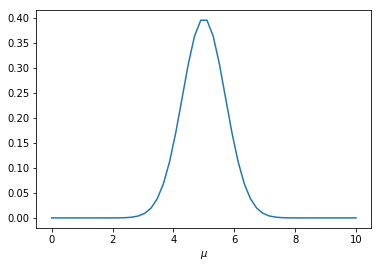

In [6]:
x_vals = np.linspace(0,10)
y_vals = (1/np.sqrt(2*np.pi))*np.exp(-(x_vals-5)**2)

plt.plot(x_vals,y_vals)
plt.xlabel('$\mu$')

# Generate walkers

In [7]:
# Generate walkers
N = 150
particles = []

#LIMITS of mu
mulimits = np.array([0,10])
mu_value = 5

logl = np.empty(N)
logp = np.empty(N)
mu_vals = np.empty(N)
for i in range(0, N):
    mu_vals[i] = generate()
    particles.append(mu_vals[i])
    logl[i] = Likelihood(mu_value,mu_vals[i]) 
    logp[i] = Prior(mu_vals[i],mulimits)

In [8]:
# Number of NS iterations
nest_steps = 1000

# MCMC steps per NS iteration
mcmc_steps = 50

# mcmc stepsize
mustep = 0.1
stepsize = np.array([mustep])

#Number of parameters
num_params = 1



# Storage for results
keep = np.empty((nest_steps, num_params + 1))

nacceptance = np.zeros(nest_steps)
nrejectance = np.zeros(nest_steps)

# Main Nest

In [9]:
for i in range(nest_steps):
    
    worst = np.argmin(logl)   # Particle with worst likelihood
    
    keep[i,:-1] = particles[worst] # Save the details of the worst particle , (m,c) and (likelihood)
    keep[i,-1] = logl[worst]
    
    # Copy random survivor
    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(particles))
        if (copy != worst):break
            
    particles[worst] = duplicate.deepcopy(particles[copy]) # Throw away worst particle and replace with random particle 
                                                            #and do mcmc from the random particle (will change with new sample)
    
    logl_threshold = duplicate.deepcopy(logl[worst])    # Likelihood of worst point
    
    naccept = 0      #count number of accepted samples
    nreject = 0     #count number of rejected samples
    for mcmci in range(mcmc_steps):   # Do mcmc on the random survivor
        theta_new = particles[worst] + stepsize * np.random.randn()  #Generate new sample
        logl_new = Likelihood(mu_value,theta_new)                                 #Likelihood of new sample
        
        logp_new = Prior(theta_new,mulimits)                           #prior prob of new sample
        
        if (logl_new>logl_threshold) and (logp_new-logp[worst])>=np.log(np.random.rand()): #Accept new sample
            particles[worst] = theta_new                                #replace worst sample with new sample
            logp[worst] = logp_new                                      # replace worstp with newp of new sample
            logl[worst] = logl_new                                      #replace worstL with newL of new sample
            
            naccept += 1                                              #increment number of accepted sample 
            
        else: # otherwise reject new sample 
            particles[worst] = particles[worst]     #stay at current position and look for new sample again
            nreject += 1
    
    nacceptance[i] = naccept/mcmc_steps #evaluate mcmc acceptance ratio



#Prior Mass    
logX = -(np.arange(0, (nest_steps))+ 1.)/N  # evalute prior mass

# Acceptance Ratio

Text(0,0.5,'Acceptance Ratio')

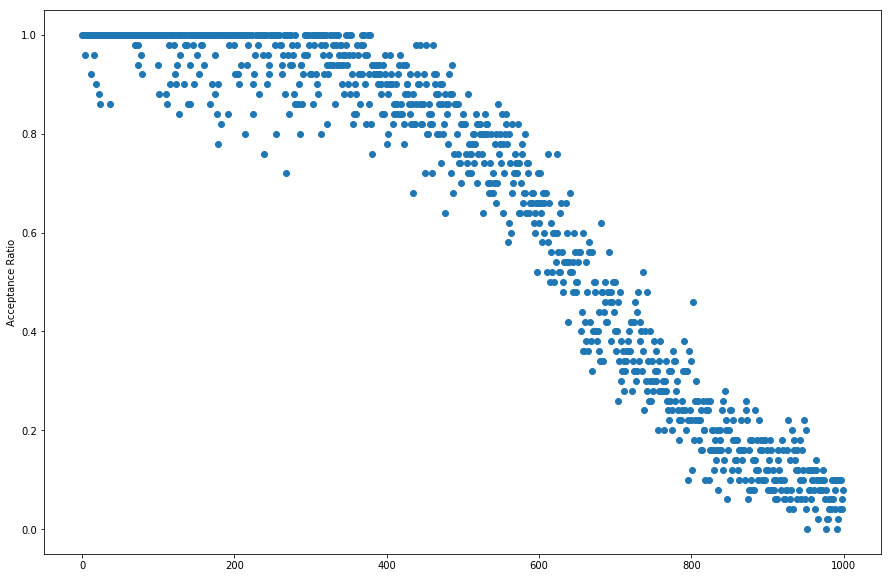

In [10]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$\\log(X)$')

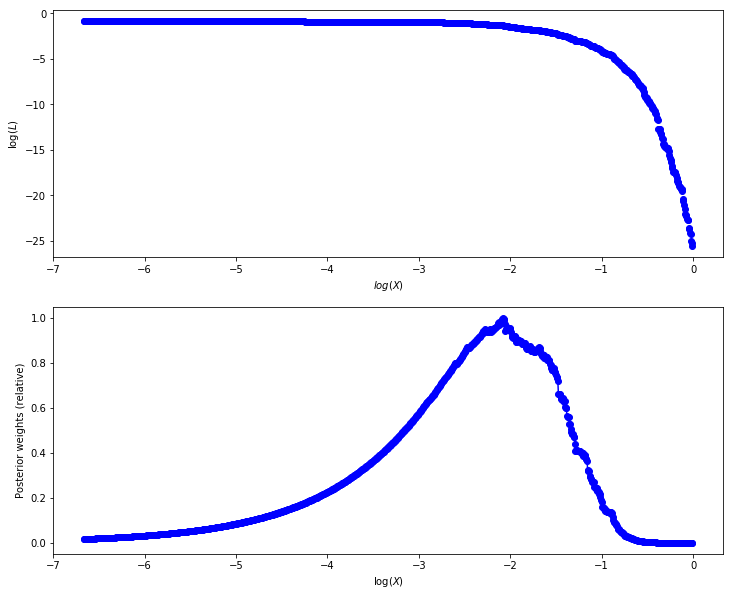

In [11]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(logX, keep[0:(nest_steps), -1], 'bo')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)

#Posterior weights

logwt = logX.copy() + keep[0:(nest_steps), -1]

wt = np.exp(logwt - logwt.max())              # Normalised posterior weights
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [12]:
# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1])

# Normalised posterior weights
wt = wt/wt.sum()

effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -2.7036749883375544 
Information = 1.2252086906628015
Effective Sample Size = 581


# Analytic Solution for Z

$$ Z = \int_{0}^{10}L(\theta)\pi(\theta)d\theta$$
$$ = \int_{0}^{10}\frac{exp(-\theta-5)^{2}}{10\sqrt(2\pi)}d\theta $$
$$ = \frac{erf(5)}{10\sqrt(2)}$$

$$ Z_{analytic} = 0.0707$$


# Comparison of the LogZ from Nested sampling and the Analytical solution

In [13]:
print("LogZ_nest  = " + str(logZ) + "\n\n" +"LogZ_analytic = "+ str(np.log(0.0707)))

LogZ_nest  = -2.7036749883375544

LogZ_analytic = -2.64930970607961


# Posterior

In [14]:
posterior_samples = np.empty((effective_sample_size, keep.shape[1]))
logX_effective = np.empty(effective_sample_size)
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        logX_effective[k] = logX[k]
        k += 1

    if k >= effective_sample_size:
        break

#np.savetxt('keep_Many.txt', posterior_samples)

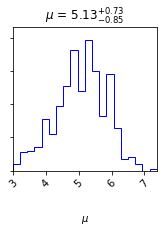

In [15]:
Fig = corner.corner(posterior_samples[:,:-1], labels=['$\mu$'],bins=20,show_titles=True,color='b',smooth=1.0);

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.7,0.9,'Blue Histogram : NS Posterior \n\n Orange : True Posterior ')

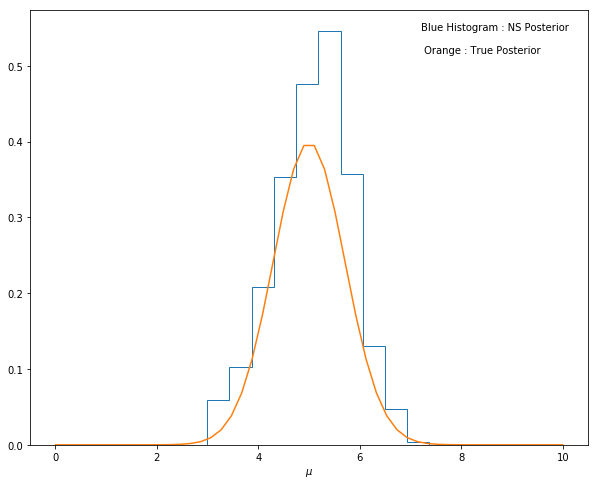

In [16]:
plt.figure(figsize=(10,8))
plt.hist(posterior_samples[:,:-1],normed=True,histtype='step');
plt.plot(x_vals,y_vals)
plt.xlabel('$\mu$')
plt.annotate("Blue Histogram : NS Posterior \n\n Orange : True Posterior ",xy=(0.7,0.9),xycoords="axes fraction")


# LogZ Distribution

In [131]:
logZ_distribution = []  #Empty list to store logZ
NZ = 5000               # LlogZ sample size

for i in range(NZ):   # Samples size
    uniform_numbers = np.log(np.random.uniform(0,1,len(keep[:,-1])))  #Generate log uniform numbers (log space)
    number_new = 0                                                    #initialize number
    logX_mass = []                                                    #store each prior mass

    for number in uniform_numbers:                                    # for each log uniform number
    
        number_new -= number                                         # x1,x2,x3 = u1,u1*u2,u1*u2*u3 etc. in log space we add
        logX_mass.append(-number_new/N)                              # store each logx..

    logw_un = logX_mass                                             #prior weights
    logw_un -= logsumexp(logw_un)                                   #normalise them

    logZ_un = logsumexp(logw_un + keep[:,-1])                        #Evaluate logZ 
    
    logZ_distribution.append(logZ_un)                                #store each logZ 
    

/home/hope-moloko/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


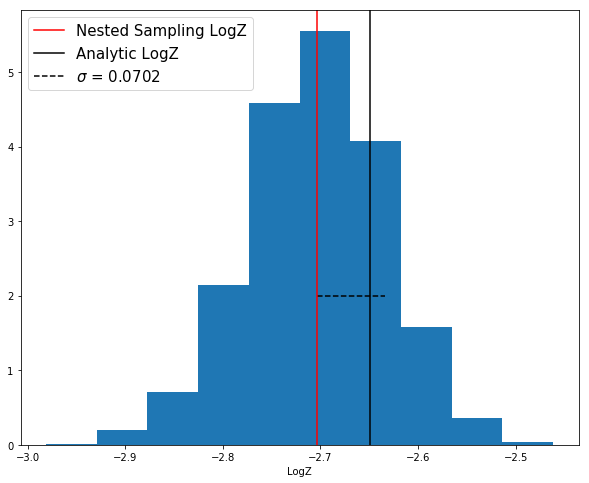

In [231]:
std = np.std(logZ_distribution)    # Standard deviation of logZ distribution

fig,ax = plt.subplots(figsize=(10,8))

ax.hist(logZ_distribution,normed=True);
ax.axvline(logZ,c='r',label = 'Nested Sampling LogZ')
ax.axvline(np.log(0.0707),c='k',label='Analytic LogZ')
ax.set_xlabel('LogZ')
ax.axes.hlines(2,logZ,logZ+std,linestyle='dashed',label='$\sigma$ = ' +str(np.round(std,4)))
ax.legend(fontsize=15)